# $\mathrm{n-C_4H_9CHO}$ (IPRCHO)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

predict_logσ_wΔ

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "n-C4H9CHO" 
nice_name = "n-C₄H₉CHO"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0  …  341.0, 342.0, 343.0, 344.0, 345.0, 346.0, 347.0, 348.0, 349.0, 350.0], [5.48e-20, 6.23e-20, 6.09e-20, 6.56e-20, 5.8e-20, 5.43e-20, 4.41e-20, 3.74e-20, 2.36e-20, 1.81e-20  …  1.67e-21, 1.14e-21, 7.3e-22, 4.8e-22, 3.5e-22, 2.8e-22, 2.3e-22, 2.0e-22, 1.7e-22, 1.5e-22], [293.0, 298.0, 298.0, 298.0], [NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], "K", "Organics (carbonyls)", "n-C4H9CHO", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2437


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,295.358,217.999,295.361,376.287,0,Float64
2,σ,2.12435e-20,2.99252e-25,1.24687e-20,6.56e-20,0,Float64
3,T,297.977,293.0,298.0,298.0,0,Float64
4,source_id,2.10464,1,2.0,4,0,Int64


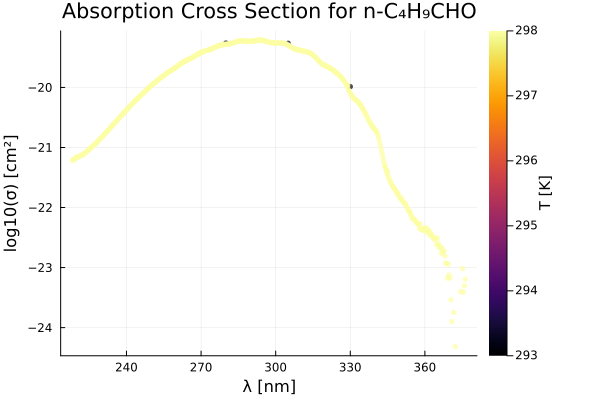

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


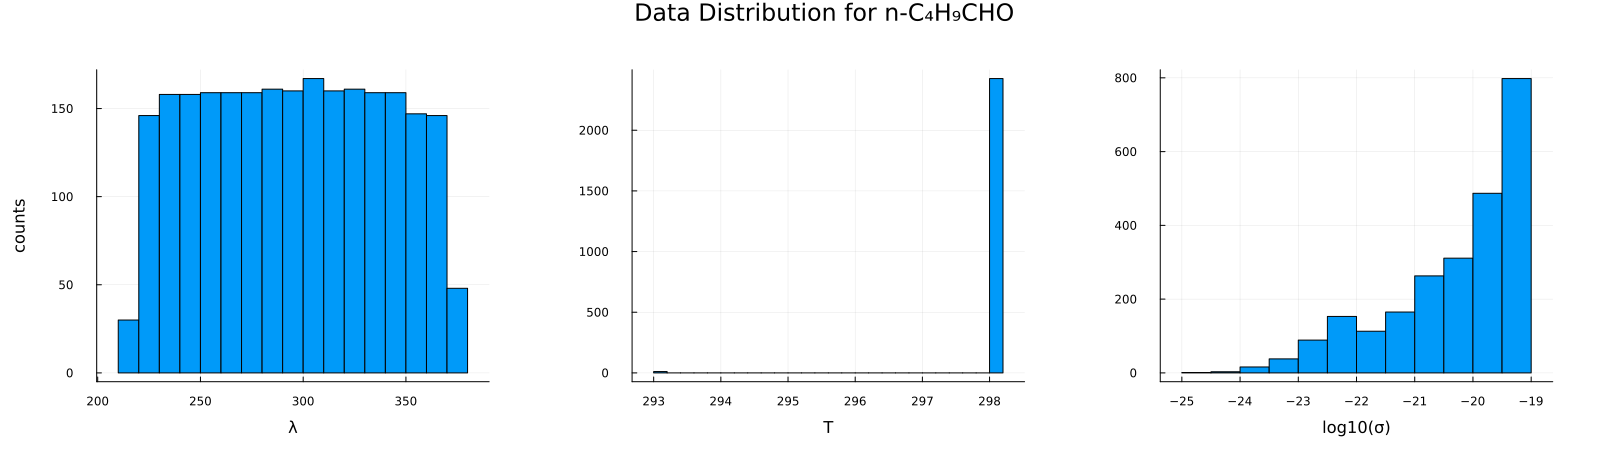

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,280.0,5.48e-20,293.0
2,285.0,6.23e-20,293.0
3,290.0,6.09e-20,293.0
4,295.0,6.56e-20,293.0
5,300.0,5.8e-20,293.0
6,305.0,5.43e-20,293.0
7,310.0,4.41e-20,293.0
8,315.0,3.74e-20,293.0
9,320.0,2.36e-20,293.0


In [13]:
function representative_rand_sample(column::AbstractVector, nbins::Int, npoints::Int)
    n_per_bin = floor(Int, npoints/nbins)
    hist = fit(Histogram, column, nbins=nbins)
    bin_edges = hist.edges[1]
    
    idx_out = []
    
    # loop over each bin
    for i ∈ 1:size(bin_edges, 1)-1
        bin_idxs = findall(ξ -> bin_edges[i] < ξ && ξ < bin_edges[i+1], column)
        n_to_sample = minimum([n_per_bin, size(bin_idxs, 1)])
        idx_res = sample(bin_idxs, n_to_sample, replace=false)
        push!(idx_out, idx_res)  # sample without replacement
    end

    return unique(vcat(idx_out...))
end

λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

217.999

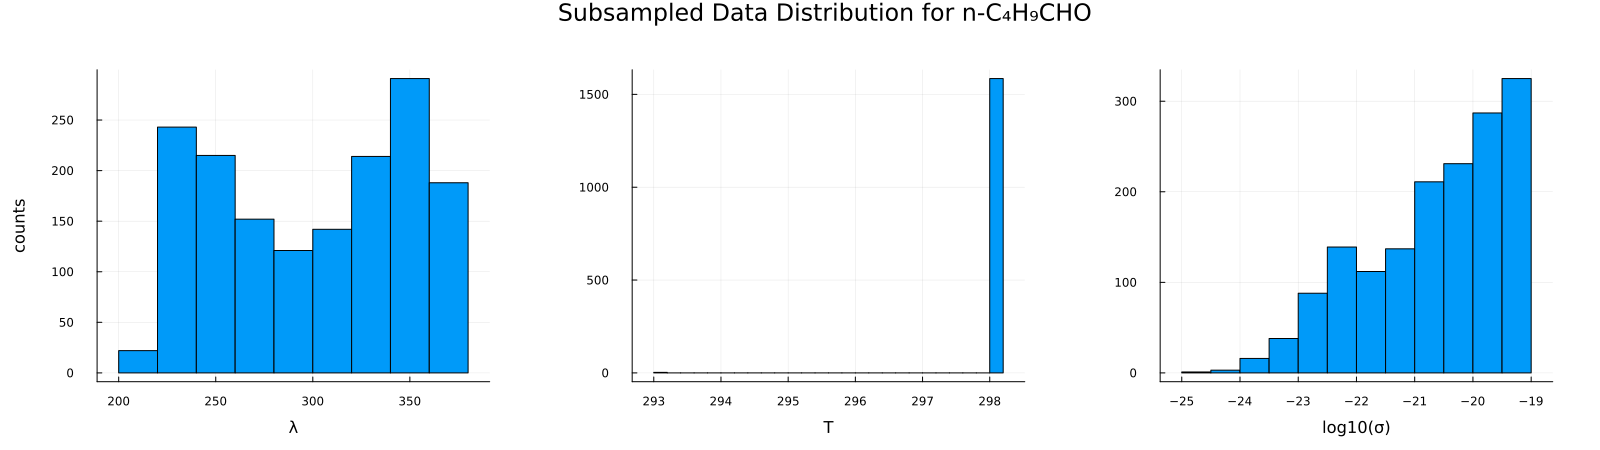

In [14]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

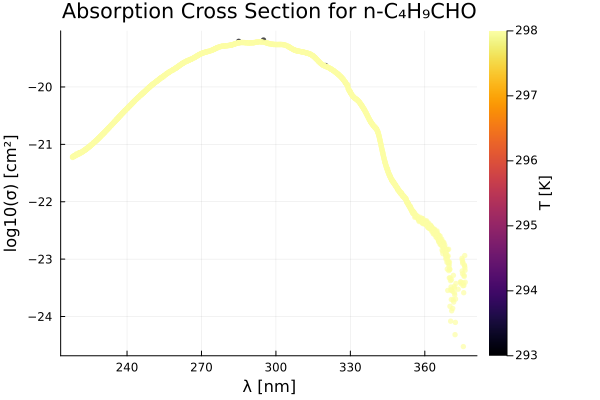

In [15]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [16]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1508


In [17]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

80-element Vector{Float64}:
 -21.711728411745177
 -19.274307202756663
 -19.227327038306463
 -19.24640545198706
 -22.251477074980393
 -19.50544748505905
 -20.799740632038823
 -20.75011221241194
 -20.441266236318782
 -20.015479887453427
 -19.296883234760983
 -21.79286132881312
 -20.435988829404852
   ⋮
 -20.2565749074313
 -20.660169089531013
 -20.93704216591549
 -22.041523557802577
 -21.210408007605917
 -19.40788878047587
 -22.355991979201985
 -20.698911378538114
 -19.51999305704285
 -19.72006170668817
 -21.066150950796015
 -19.968595575715835

In [66]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 10
σf² = var(ytrain)
println(σf²)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

1.405523738514819


mykernel (generic function with 1 method)

In [67]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.3404099903494677, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.9039206482219826, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.7035902485647518, exp, 1.4901161193847656e-8)), 
  σ² = 0.014055237385148191, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [68]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -9.763537e+02     3.649359e+02
 * time: 0.0024449825286865234
     1    -1.202940e+03     2.136069e+02
 * time: 4.4176859855651855
     2    -1.723469e+03     2.745987e+02
 * time: 5.4117889404296875
     3    -1.842652e+03     1.431452e+02
 * time: 6.16782808303833
     4    -1.877731e+03     1.693722e+02
 * time: 6.933475971221924
     5    -1.928470e+03     6.434057e+01
 * time: 8.005218982696533
     6    -1.941940e+03     1.161942e+02
 * time: 9.084810018539429
     7    -1.948637e+03     1.285238e+01
 * time: 9.884215116500854
     8    -1.949076e+03     4.602638e+00
 * time: 10.938034057617188
     9    -1.949100e+03     6.647836e-01
 * time: 12.013833045959473
    10    -1.949105e+03     3.690942e-01
 * time: 33.419069051742554
    11    -1.949103e+03     2.919574e-01
 * time: 53.20174312591553
    12    -1.949103e+03     1.065403e-01
 * time: 72.76942205429077
    13    -1.949104e+03     4.004999e-02
 * time: 73.87036108970642

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @850 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @124 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [69]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.682431217928923, 1.7646886966151953, -1.6900357314860042, -5.742911637246267],
 minimum = -1949.1010934220799,
 iterations = 524,
 converged = false,)

In [77]:
fp = fitted_params(mach)

(θ_best = [:σf² => 39.74290037793602, :ℓ_λ => 5.83975415476293, :ℓ_T => 0.18451294585515166],
 σ² = 0.0032054365510140667,)

In [70]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


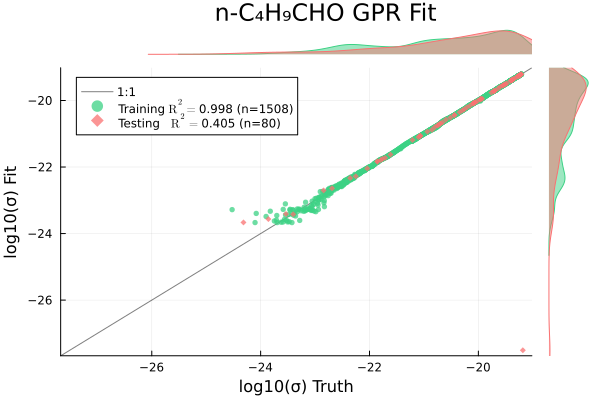

In [71]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


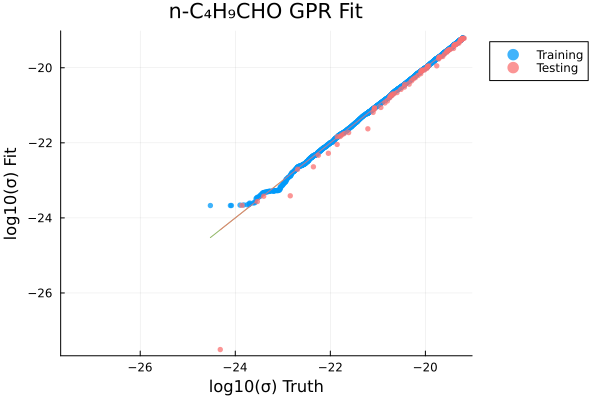

In [72]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


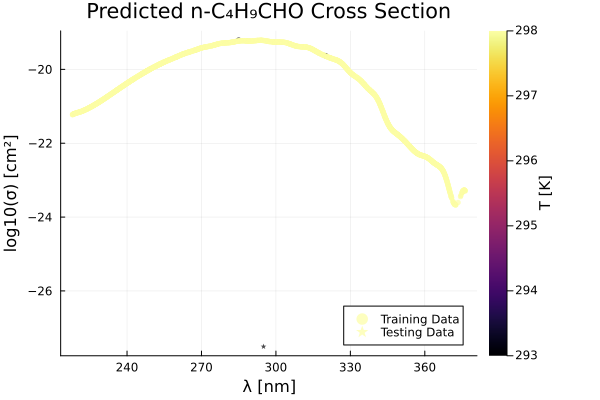

In [73]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

217.999
376.287


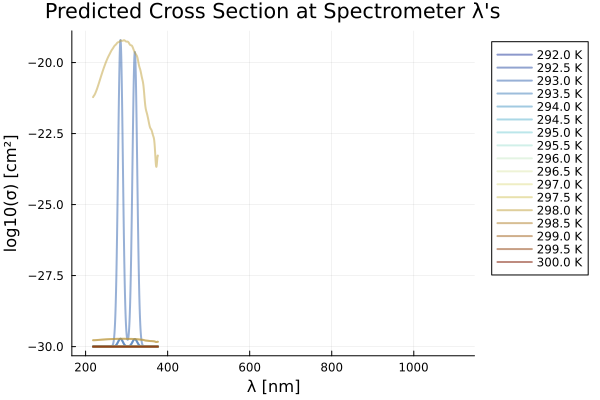

In [74]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

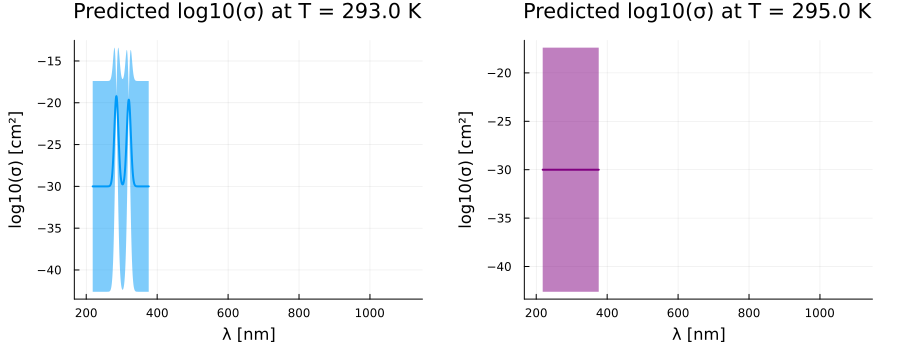

In [76]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 293.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 295.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 